In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load your dataset
# Assuming the dataset has a column named 'Date' and 'Price'
# Replace 'your_dataset.csv' with the actual file path or dataset source
df = pd.read_csv('https://raw.githubusercontent.com/Rising-Stars-by-Sunshine/Lareina/main/Data/sugarprice.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Extract the target variable
y = df['sugar_world'].values

# Feature scaling (normalization)
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# Create sequences for the LSTM model
def create_sequences(data, sequence_length):
    sequences = []
    target = []
    for i in range(len(data) - sequence_length + 1):  # Adjusted loop range
        seq = data[i:i + sequence_length]
        label = data[i + sequence_length - 1]  # Adjusted label position
        sequences.append(seq)
        target.append(label)
    return np.array(sequences), np.array(target)

# Define sequence length (number of time steps to look back)
sequence_length = 48  # Adjusted based on the error message

# Create sequences and targets
X, y = create_sequences(y_scaled, sequence_length)

# Reshape input data to be 3D [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=50, batch_size=32)

# Make predictions for future dates
future_dates = pd.date_range(start=df.index[-1], periods=230, freq='M')[1:]
future_inputs = y_scaled[-sequence_length:]
future_inputs = np.reshape(future_inputs, (1, sequence_length, 1))

future_predictions_scaled = []

for _ in range(len(future_dates)):
    future_prediction_scaled = model.predict(future_inputs)[0][0]
    future_predictions_scaled.append(future_prediction_scaled)

    # Append the new prediction to future_inputs
    future_inputs = np.append(future_inputs[:, 1:, :], future_prediction_scaled)
    future_inputs = np.reshape(future_inputs, (1, sequence_length, 1))

# Inverse transform the predictions to get actual prices
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

# Create a DataFrame with future dates and predicted prices
future_predictions_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['Predicted_Price'])

# Display the predictions
print(future_predictions_df)




Epoch 1/50
23/23 [==============================] - 11s 122ms/step - loss: 0.0141
Epoch 2/50
23/23 [==============================] - 2s 84ms/step - loss: 0.0051
Epoch 3/50
23/23 [==============================] - 2s 85ms/step - loss: 0.0040
Epoch 4/50
23/23 [==============================] - 1s 61ms/step - loss: 0.0031
Epoch 5/50
23/23 [==============================] - 1s 39ms/step - loss: 0.0027
Epoch 6/50
23/23 [==============================] - 1s 40ms/step - loss: 0.0021
Epoch 7/50
23/23 [==============================] - 1s 39ms/step - loss: 0.0018
Epoch 8/50
23/23 [==============================] - 1s 38ms/step - loss: 0.0018
Epoch 9/50
23/23 [==============================] - 1s 39ms/step - loss: 0.0014
Epoch 10/50
23/23 [==============================] - 1s 62ms/step - loss: 0.0011
Epoch 11/50
23/23 [==============================] - 2s 66ms/step - loss: 0.0013
Epoch 12/50
23/23 [==============================] - 1s 40ms/step - loss: 0.0010
Epoch 13/50
23/23 [================

In [2]:
future_predictions_df.to_csv('predictprice.csv')

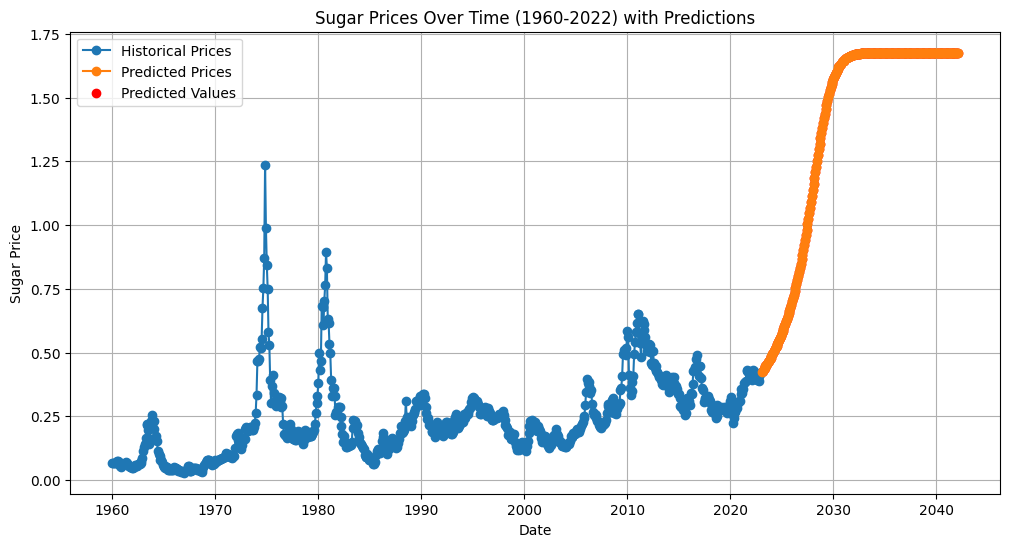

In [3]:
import matplotlib.pyplot as plt

# Assuming df is your original DataFrame with historical prices
# and future_predictions_df is the DataFrame containing predicted prices

# Plotting historical prices
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['sugar_world'], label='Historical Prices', marker='o')

# Plotting predicted prices
plt.plot(future_predictions_df.index, future_predictions_df['Predicted_Price'], label='Predicted Prices', marker='o')

# Highlighting the predicted values
plt.scatter(future_predictions_df.index, future_predictions_df['Predicted_Price'], color='red', label='Predicted Values')

plt.title('Sugar Prices Over Time (1960-2022) with Predictions')
plt.xlabel('Date')
plt.ylabel('Sugar Price')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
from sklearn.metrics import r2_score, mean_squared_error

# Assuming y_test is the actual target values and predicted_values is the predicted values
# You should replace these with the actual variables from your test set

# Inverse transform the test set and predictions (if you used MinMaxScaler)
y_test_actual = scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()
predicted_values_actual = scaler.inverse_transform(future_predictions.reshape(-1, 1)).flatten()

# Print the lengths of the arrays to diagnose the issue
print(f'Length of y_test_actual: {len(y_test_actual)}')
print(f'Length of predicted_values_actual: {len(predicted_values_actual)}')

# Calculate R-squared
r2 = r2_score(y_test_actual, predicted_values_actual)
print(f'R-squared: {r2:.4f}')

# Calculate Mean Squared Error
mse = mean_squared_error(y_test_actual, predicted_values_actual)
print(f'Mean Squared Error: {mse:.4f}')


Length of y_test_actual: 756
Length of predicted_values_actual: 229


ValueError: Found input variables with inconsistent numbers of samples: [756, 229]